# Part 1 Convolutional Neural Network for Fashion Product Classification

### Imports

In [77]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Load train and test labels

In [8]:
test = pd.read_csv("test.csv",
           header=0, 
           sep="	")
test

,imageid,label,productname
0,21131,Topwear,s.Oliver Women Solid White Top
1,27837,Others,Bulchee Men Plain Jeans Black Belt
2,47649,Shoes,Carlton London Men Brown Shoes
3,49717,Others,Park Avenue Black & Red Checked Tie
4,4868,Topwear,Levis Kids Boy's Darby Orange Polo Tshirt
...,...,...,...
3995,7928,Topwear,Proline Men Olive Green Polo T-shirt
3996,21254,Bags,Skybags Unisex Maroon Duffle Bag
3997,58463,Others,Fossil Men Black Belt
3998,38025,Watches,Q&Q Women Steel Dial Watch


In [9]:
train = pd.read_csv("train.csv",
           header=0, 
           sep="	")
train

,imageid,label,productname
0,2653,Bags,Murcia Women Leather Office Grey Bag
1,55997,Others,Colorbar Velvet Matte Temptation Lipstick 24MA
2,2640,Shoes,Carlton London Men Brown Formal Shoes
3,40565,Topwear,W Women Maroon Kurta
4,38932,Bottomwear,Gini and Jony Girls Pink Leggings
...,...,...,...
40436,5815,Topwear,Puma Men's Sports Grey T-shirt
40437,55200,Others,Lakme Lip Love Charmer Lip Conditioner
40438,11294,Bottomwear,Wrangler Men Blue Floyd Jeans
40439,30620,Topwear,Nike Men Printed Green T-shirt


### Load the images

Since there are a few grayscale images in the dataset, I decided to omit them.  I imagine any modern and quality product listing would have a colour image. 

In [38]:
def load_images(labels):
    images = []
    grayscale_img_ids = []
    for fname in labels['imageid']:
        img_arr = np.asarray(Image.open(os.path.join("images", str(fname)+".jpg")).resize((60, 80)))
        
        # don't add the image if its not RGB
        if len(img_arr.shape)<3:
            grayscale_img_ids.append(fname)
        else:
            images.append(img_arr/255.0)
    
    # the remove grayscale labels
    labels = labels[~labels['imageid'].isin(grayscale_img_ids)].copy()
    
    return labels, np.asarray(images) 

In [39]:
test_labels, test_images = load_images(test)

In [40]:
train_labels, train_images = load_images(train)

In [41]:
labels = train_labels['label'].unique().tolist()
labels

['Bags',
 'Others',
 'Shoes',
 'Topwear',
 'Bottomwear',
 'Innerwear',
 'Eyewear',
 'Jewellery',
 'Sandal',
 'Watches',
 'Fragrance',
 'Wallets',
 'Makeup']

### Prepare training data

In [42]:
y_train = to_categorical(train_labels["label"].apply(lambda x: labels.index(x)).to_numpy())
y_test = to_categorical(test_labels["label"].apply(lambda x: labels.index(x)).to_numpy())
x_train = train_images
x_test = test_images

In [43]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(40053, 80, 60, 3)
(40053, 13)
(3957, 80, 60, 3)
(3957, 13)


#### Show an example image

Others


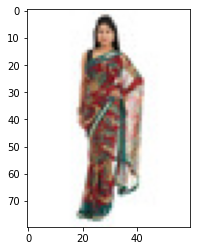

In [44]:
num = 1279
print(labels[np.argmax(y_test[num])])
plt.imshow(x_test[num])

#### Show the distribution of classes

In [2]:
train_labels['label'].value_counts() / len(train_labels)*100

NameError: name 'train_labels' is not defined

### Model Design

In [56]:
model_input = Input(shape=(80, 60, 3), name='img')

x = Conv2D(16, 3, activation='relu')(model_input)
x = MaxPool2D(pool_size=2)(x)
x = Dropout(0.1)(x)

x = Conv2D(32, 3, activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)
x = Dropout(0.1)(x)

x = Conv2D(64, 3, activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)
x = Dropout(0.1)(x)

x = Conv2D(128, 3, activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)
x = Dropout(0.1)(x)


x = Flatten()(x)
x = Dense(128, activation='relu')(x)
model_output = Dense(13, activation='softmax')(x)

cnn = Model(model_input, model_output, name="simplecnn")
cnn.summary()


Model: "simplecnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 80, 60, 3)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 78, 58, 16)        448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 39, 29, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 39, 29, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 37, 27, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 18, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 13, 32)        0 

In [57]:
cnn.compile(optimizer = "adam", 
           loss = "CategoricalCrossentropy",
           metrics=["accuracy"])

### Train Model

In [58]:
history = cnn.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10)

Epoch 1/10
1252/1252 [==============================] - 7s 5ms/step - loss: 1.0229 - accuracy: 0.6824 - val_loss: 0.3882 - val_accuracy: 0.8792
Epoch 2/10
1252/1252 [==============================] - 6s 5ms/step - loss: 0.3713 - accuracy: 0.8854 - val_loss: 0.3156 - val_accuracy: 0.9007
Epoch 3/10
1252/1252 [==============================] - 6s 5ms/step - loss: 0.3012 - accuracy: 0.9039 - val_loss: 0.2395 - val_accuracy: 0.9232
Epoch 4/10
1252/1252 [==============================] - 6s 5ms/step - loss: 0.2568 - accuracy: 0.9170 - val_loss: 0.2240 - val_accuracy: 0.9282
Epoch 5/10
1252/1252 [==============================] - 6s 5ms/step - loss: 0.2306 - accuracy: 0.9259 - val_loss: 0.2297 - val_accuracy: 0.9320
Epoch 6/10
1252/1252 [==============================] - 6s 5ms/step - loss: 0.2058 - accuracy: 0.9312 - val_loss: 0.2066 - val_accuracy: 0.9308
Epoch 7/10
1252/1252 [==============================] - 6s 5ms/step - loss: 0.1883 - accuracy: 0.9401 - val_loss: 0.2140 - val_accuracy:

### Visualize Results

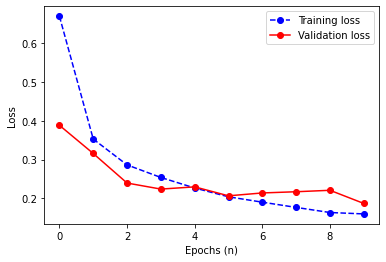

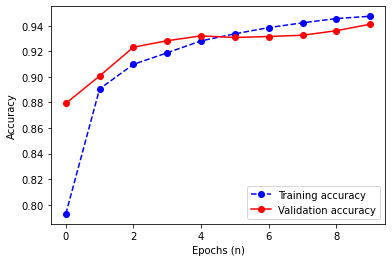

In [59]:
plt.plot(history.history['loss'], 'bo--')
plt.plot(history.history['val_loss'], 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epochs (n)')
plt.legend(['Training loss', 'Validation loss'])
plt.show()
plt.plot(history.history['accuracy'], 'bo--')
plt.plot(history.history['val_accuracy'], 'ro-')
plt.ylabel('Accuracy')
plt.xlabel('Epochs (n)')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show()

In [ ]:
train_loss, train_acc = cnn.evaluate(x=x_train, y=y_train)
print("The model performed with a training accuracy of {:.2f}%".format(test_acc*100))

In [113]:
test_loss, test_acc = cnn.evaluate(x=x_test, y=y_test)
print("The model performed with a testing accuracy of {:.2f}%".format(test_acc*100))

124/124 [==============================] - 0s 2ms/step - loss: 0.1870 - accuracy: 0.9411
The model performed with and accuracy of 94.11%


In [73]:
preds = cnn.predict(x_test)
preds = preds.argmax(1)
true = y_test.argmax(1)

<AxesSubplot:>

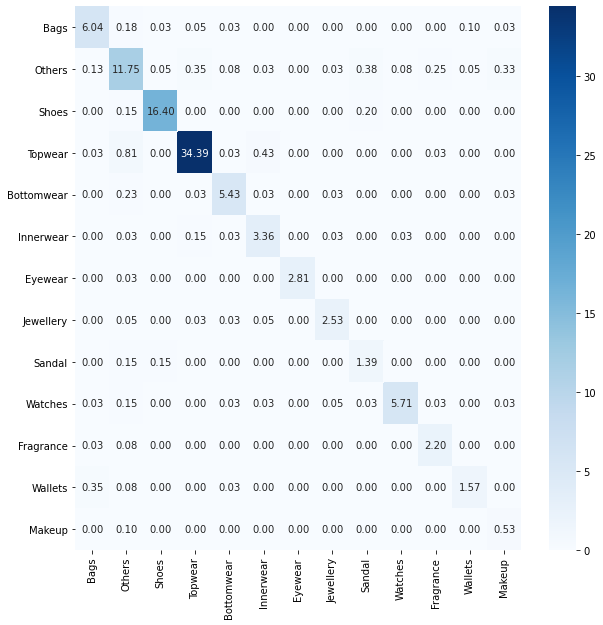

In [114]:
cm = confusion_matrix(true, preds)

plt.figure(figsize=(10,10))
sns.heatmap(cm/np.sum(cm)*100, annot=True, cmap='Blues', fmt='.2f', xticklabels=labels, yticklabels=labels)

<AxesSubplot:>

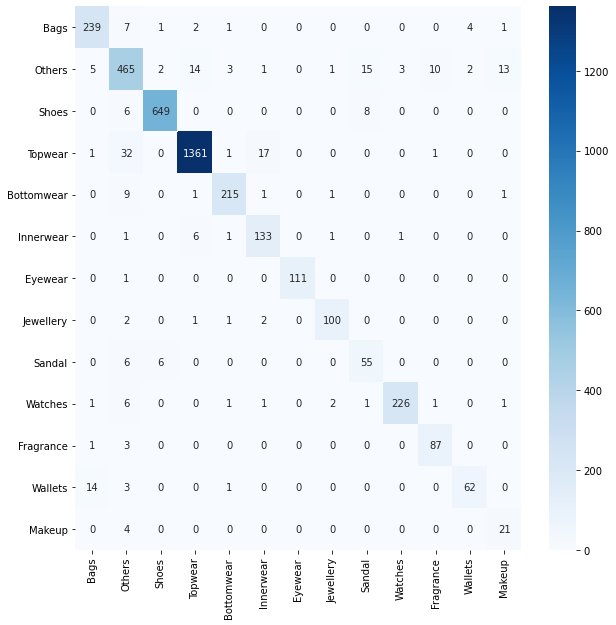

In [101]:
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f', xticklabels=labels, yticklabels=labels)

#### Check to ensure distribution of predictions matches distribution of labels

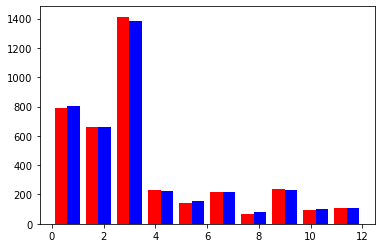

In [116]:
_ = plt.hist([preds, true], color=['r', 'b'])

We see that the distributions are very similar, which indicates that our model is learning each class, not just focusing on the top most frequent classes and almost never predicting rare classes.  
Therefore our model is handling the uneven distribution of class examples well. 